In [1]:
import pandas as pd
import numpy as np
dfA0 = pd.read_csv('/Users/jackarmand/Downloads/A0.csv')
dfA0.set_index('LID',inplace=True)
dfA1 = pd.read_csv('/Users/jackarmand/Downloads/A1.csv')
dfA1.set_index('LID',inplace=True)
dfA2 = pd.read_csv('/Users/jackarmand/Downloads/A2.csv')
dfA2.set_index('LID',inplace=True)

dfCF0 = pd.read_csv('/Users/jackarmand/Downloads/CASH_FLOW0.csv')
dfCF1 = pd.read_csv('/Users/jackarmand/Downloads/CASH_FLOW1.csv')

In [2]:
#Function to aggregate cash flows into statistics for each loan ID
def create_CF_summary(df):
    summary_df = pd.DataFrame()
    summary_df['Cumulative Payment'] = df.groupby('LID').sum()['PAYMENT']
    summary_df['Length'] = df.groupby('LID').max()['LOAN_AGE']
    return summary_df

In [3]:
def create_month_dataframes(df,l1):
    dfs = []
    for i in l1:
        df_i = df.loc[df['LOAN_AGE']<(i+1)]
        df_sum_i = create_CF_summary(df_i)
        dfs.append(df_sum_i)
    return dfs

In [4]:
#List of dataframes for both 0 and 1, each dataframe cuts off any months past loan age=M
#This seemed to me to be the easiest way to get cumulative payments and active or not for different
#values for M
list_of_dfs_0 = create_month_dataframes(dfCF0,[12,24,36,48,60])
list_of_dfs_1 = create_month_dataframes(dfCF1,[12,24,36,48,60])

In [5]:
#Creating Cumulative Payment to different Ms and Active at different Ms for data "1" and data "0"
dfCF0_summary = create_CF_summary(dfCF0)
dfCF1_summary = create_CF_summary(dfCF1)

#dfCF0_summary['Active_12']
for i in [12,24,36,48,60]:
    name = 'Active_'+str(i)
    dfCF0_summary[name] = np.where(dfCF0_summary['Length']>(i-1),1,0)
count = 0
for i in list_of_dfs_0:
    count+=1
    name_num = count*12
    name = 'Cumulative_Payment_'+str(name_num)
    dfCF0_summary[name] = i['Cumulative Payment']

for i in [12,24,36,48,60]:
    name = 'Active_'+str(i)
    dfCF1_summary[name] = np.where(dfCF1_summary['Length']>(i-1),1,0)
count = 0
for i in list_of_dfs_1:
    count+=1
    name_num = count*12
    name = 'Cumulative_Payment_'+str(name_num)
    dfCF1_summary[name] = i['Cumulative Payment']

# Summary Stats for Data "0"
- Mean loan length: 32.3
- Loan length STD: 34.722
- Mean Cum Payment (total): 158545.5
- Cum Payment STD: 71979

In [7]:
#Graph of Loan Lengths by date
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter(x=result_df.groupby(['FIRST_PMT_DATE']).mean().index,y=result_df.groupby(['FIRST_PMT_DATE']).mean()['Length'],mode='markers')])
fig

NameError: name 'result_df' is not defined

### Loan length looks to decrease monotonically as date increases, so thought that it looked like replacing dates simply with increases integers would be a fine way to go about it

# Determining if categories seem to have a big effect on outcome, and how is best to represent them
### Note: Used .groupby(column_name).mean() to see if different cats had large diffs in means
- SELLER
    - No lengths or payments for any seller are >1 STD away from mean, unsure if its worth using this category
- STATE
    - Guam has >> Loan Length
    - Looks like it is possible that states effect loan value on average. Think it may be a good idea to use state population density as a metric to use for state (or maybe statistics for average home price??)
- OCHANNEL
    - Only 3 categories so probably worth using hot encoding
- OCC_STATUS
    - Also only 3 categories, and seems to have a pretty good different in length and payment
- REL_MORT_IND
    - Only two categories can just use binary
- PROD_TYPE
    - Only one category, just delete
- ORIG_DATE
    - Length decreases monotoically as time increases
    - Cumulative payment looks as though it possibly increases as time increases
    - Either way, seems like replacing with integers that just count up would work well to represent the data as there it moves linearly
- FIRST_PMT_DATE
    - super similar to ORIG_DATE, only need one
- FIRST_TIME_IND
    - 3 categories, seem to possibly have a difference so will probably keep this
- LOAN_PURPOSE
    - 4 categories, again OHE seems to be the best way most likely
- PROPERTY_TYPE
    - 5 categories, once again OHE or hashing seems to be best

In [8]:
def regression_fill(df,list_of_labels):
    df = df[list_of_labels]
    ols = LinearRegression()
    df_train = df.dropna(axis=0,how='any')
    X_train = np.asarray(df_train[list_of_labels[0]]).reshape(-1,1)
    y_train = df_train[list_of_labels[1]]
    model = ols.fit(X_train,y_train)
    for i in range(len(df[list_of_labels[0]])):
        try:
            if df[list_of_labels[0]].iloc[i] != 'naN':
                df[list_of_labels[1]].iat[i] = model.predict(np.asarray(df[list_of_labels[0]].iloc[i]).reshape(-1,1))
        except:
            pass
    return df

In [10]:
getting_avg_len = pd.concat([dfCF0_summary,dfA0],axis='columns')

#ZIP
gal = getting_avg_len.groupby('ZIP').mean()
zips = list(gal.index)
lens = list(gal['Length'])
upbs = list(gal['UPB'])
active_percent_list = []
cumulative_payment_at_time_avgs = []
for i in [12,24,36,48,60]:    
    name_active = 'Active_'+str(i)
    name_cum = 'Cumulative_Payment_'+str(i)
    active_percent_list.append(gal[name_active])
    cumulative_payment_at_time_avgs.append(list(gal[name_cum]))
    

#STATE
gal_state = getting_avg_len.groupby('STATE').mean()
states = list(gal_state.index)
state_lens = list(gal_state['Length'])
state_upbs = list(gal_state['UPB'])
state_active_percent_list = []
state_cumulative_payment_at_time_avgs = []
for i in [12,24,36,48,60]:    
    name_active = 'Active_'+str(i)
    name_cum = 'Cumulative_Payment_'+str(i)
    state_active_percent_list.append(list(gal_state[name_active]))
    state_cumulative_payment_at_time_avgs.append(list(gal_state[name_cum]))

In [11]:
income_stats = pd.read_csv('/Users/jackarmand/Documents/Income Statistics States.csv')
income_stats = income_stats[['Median Household Income','State']]
dfA0u = dfA0.copy()
dfA0u['STATE_MEDIAN_INCOME'] = dfA0['STATE'].replace(list(income_stats['State']),list(income_stats['Median Household Income']))
dfA0u['STATE_MEDIAN_INCOME'] = dfA0u['STATE_MEDIAN_INCOME'].astype(int)
dfA0u['STATE_LL'] = dfA0u['STATE'].replace(states,state_lens)
dfA0u['STATE_UPB'] = dfA0u['STATE'].replace(states,state_upbs)
#for i in [12,24,36,48,60]:
    #num = int((i/12)-1)
    #name_active = 'State_Active_'+str(i)
    #name_cum = 'State_Cumulative_Payment_'+str(i)
    #dfA0u[name_active] = dfA0u['STATE'].replace(states,state_active_percent_list[num])
    #dfA0u[name_cum] = dfA0u['STATE'].replace(states,state_cumulative_payment_at_time_avgs[num])

dfA0u['ZIP_LL'] = dfA0u['ZIP'].replace(zips,lens)
dfA0u['ZIP_UPB'] = dfA0u['ZIP'].replace(zips,upbs)
#for i in [12,24,36,48,60]:
    #num = int((i/12)-1)
    #name_active = 'ZIP_Active_'+str(i)
    #name_cum = 'ZIP_Cumulative_Payment_'+str(i)
    #dfA0u[name_active] = dfA0u['ZIP'].replace(zips,active_percent_list[num])
    #dfA0u[name_cum] = dfA0u['ZIP'].replace(zips,cumulative_payment_at_time_avgs[num])

dfA0u = pd.get_dummies(dfA0u,columns=['OCHANNEL','OCC_STATUS','FIRST_TIME_IND','LOAN_PURPOSE','PROPERTY_TYPE'])

l1 = list(dfA0u.groupby(['FIRST_PMT_DATE']).mean().index)
date_ints = []
for i in range(len(l1)):
    date_ints.append(i)
l1.sort()
dfA0u = dfA0u.replace(l1,date_ints)

dfA0u['REL_MORT_IND'] = dfA0u['REL_MORT_IND'].astype('category').cat.codes

In [17]:
#Simply drop any NaN rows to get a complete set to train with
dfA0_training = dfA0u.select_dtypes(include=['float64','int64','int8','uint8'])
dfA0_training['Cumulative Payment'] = dfCF0_summary['Cumulative Payment'].copy()
dfA0_training = dfA0_training.dropna(axis=0,how='any')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
from sklearn.linear_model import LinearRegression
dfA0r = dfA0u.select_dtypes(include=['float64','int64','int8','uint8'])
l1 = [['LTV','MORT_INS_PCT'],['MORT_INS_PCT','LTV'],['CREDIT_SCORE','CO_CREDIT_SCORE'],['CO_CREDIT_SCORE','CREDIT_SCORE']]
for i in l1:
    regression_fill(dfA0r,i)
dfA0r = dfA0r.fillna(dfA0r.mean())

In [21]:
income_stats = pd.read_csv('/Users/jackarmand/Documents/Income Statistics States.csv')
income_stats = income_stats[['Median Household Income','State']]
state_replace = {'STATE':{list(income_stats['Median Household Income'])[i]:list(income_stats['State'])[i] for i in range(len(income_stats))}}
dfA1u = dfA1.copy()
dfA1u['STATE_MEDIAN_INCOME'] = dfA1['STATE'].replace(list(income_stats['State']),list(income_stats['Median Household Income']))
dfA1u['STATE_MEDIAN_INCOME'] = dfA1u['STATE_MEDIAN_INCOME'].astype(int)
dfA1u['STATE_LL'] = dfA1u['STATE'].replace(states,state_lens)
dfA1u['STATE_UPB'] = dfA1u['STATE'].replace(states,state_upbs)
#for i in [12,24,36,48,60]:
    #num = int((i/12)-1)
    #name_active = 'State_Active_'+str(i)
    #name_cum = 'State_Cumulative_Payment_'+str(i)
    #dfA1u[name_active] = dfA1u['STATE'].replace(states,state_active_percent_list[num])
    #dfA1u[name_cum] = dfA1u['STATE'].replace(states,state_cumulative_payment_at_time_avgs[num])

dfA1u['ZIP_LL'] = dfA1u['ZIP'].replace(zips,lens)
dfA1u['ZIP_UPB'] = dfA1u['ZIP'].replace(zips,upbs)
#for i in [12,24,36,48,60]:
    #num = int((i/12)-1)
    #name_active = 'ZIP_Active_'+str(i)
    #name_cum = 'ZIP_Cumulative_Payment_'+str(i)
    #dfA1u[name_active] = dfA1u['ZIP'].replace(zips,active_percent_list[num])
    #dfA1u[name_cum] = dfA1u['ZIP'].replace(zips,cumulative_payment_at_time_avgs[num])


dfA1u = pd.get_dummies(dfA1u,columns=['OCHANNEL','OCC_STATUS','FIRST_TIME_IND','LOAN_PURPOSE','PROPERTY_TYPE'])

l2 = list(dfA1u.groupby(['FIRST_PMT_DATE']).mean().index)
date_ints2 = []
for i in range(len(l2)):
    date_ints2.append(i)
l2.sort()
dfA1u = dfA1u.replace(l2,date_ints2)

dfA1u['REL_MORT_IND'] = dfA1u['REL_MORT_IND'].astype('category').cat.codes

In [11]:
income_stats = pd.read_csv('/Users/jackarmand/Documents/Income Statistics States.csv')
income_stats = income_stats[['Median Household Income','State']]
state_replace = {'STATE':{list(income_stats['Median Household Income'])[i]:list(income_stats['State'])[i] for i in range(len(income_stats))}}
dfA1u = dfA1.copy()
dfA1u['STATE_MEDIAN_INCOME'] = dfA1['STATE'].replace(list(income_stats['State']),list(income_stats['Median Household Income']))
dfA1u['STATE_MEDIAN_INCOME'] = dfA1u['STATE_MEDIAN_INCOME'].astype(int)
dfA1u['STATE_LL'] = dfA1u['STATE'].replace(states,state_lens)
dfA1u['STATE_UPB'] = dfA1u['STATE'].replace(states,state_upbs)
#for i in [12,24,36,48,60]:
    #num = int((i/12)-1)
    #name_active = 'State_Active_'+str(i)
    #name_cum = 'State_Cumulative_Payment_'+str(i)
    #dfA1u[name_active] = dfA1u['STATE'].replace(states,state_active_percent_list[num])
    #dfA1u[name_cum] = dfA1u['STATE'].replace(states,state_cumulative_payment_at_time_avgs[num])

dfA1u['ZIP_LL'] = dfA1u['ZIP'].replace(zips,lens)
dfA1u['ZIP_UPB'] = dfA1u['ZIP'].replace(zips,upbs)
#for i in [12,24,36,48,60]:
    #num = int((i/12)-1)
    #name_active = 'ZIP_Active_'+str(i)
    #name_cum = 'ZIP_Cumulative_Payment_'+str(i)
    #dfA1u[name_active] = dfA1u['ZIP'].replace(zips,active_percent_list[num])
    #dfA1u[name_cum] = dfA1u['ZIP'].replace(zips,cumulative_payment_at_time_avgs[num])


dfA1u = pd.get_dummies(dfA1u,columns=['OCHANNEL','OCC_STATUS','FIRST_TIME_IND','LOAN_PURPOSE','PROPERTY_TYPE'])

l2 = list(dfA1u.groupby(['FIRST_PMT_DATE']).mean().index)
date_ints2 = []
for i in range(len(l2)):
    date_ints2.append(i)
l2.sort()
dfA1u = dfA1u.replace(l2,date_ints2)

dfA1u['REL_MORT_IND'] = dfA1u['REL_MORT_IND'].astype('category').cat.codes

In [22]:
#Testing to see if using regression fill would work better on all variables with NaN values, not just the ones with highly correlated other statistics as I have done up to this point
from sklearn.model_selection import train_test_split

dfA1nn = dfA1u.dropna(axis=1,how='any')
dfA1nn = dfA1nn.select_dtypes(include=['float64','int64','int8','uint8'])
dfA1nn['DTI'] = dfA1u['DTI'].copy()
dfA1nn = dfA1nn.dropna(axis=0,how='any')
X = dfA1nn.drop('DTI',axis=1)
y = dfA1nn['DTI']
ols = LinearRegression()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
model = ols.fit(X_train,y_train)
ptest = model.predict(X_test)
ptestavg = []
for i in range(len(y_test)):
    ptestavg.append(y_train.mean())

from sklearn.metrics import r2_score, mean_squared_error
r2_score(y_test,ptest)
print(mean_squared_error(y_test,ptest)**0.5)
print(mean_squared_error(y_test,ptestavg)**0.5)

11.879917098385404
12.063001247796732


In [23]:
dfA1r = dfA1u.select_dtypes(include=['float64','int64','int8','uint8'])            
l1 = [['LTV','MORT_INS_PCT'],['MORT_INS_PCT','LTV'],['CREDIT_SCORE','CO_CREDIT_SCORE'],['CO_CREDIT_SCORE','CREDIT_SCORE']]
for i in l1:
    regression_fill(dfA1r,i)
dfA1r = dfA1r.fillna(dfA1r.mean())

In [67]:
income_stats = pd.read_csv('/Users/jackarmand/Documents/Income Statistics States.csv')
income_stats = income_stats[['Median Household Income','State']]
state_replace = {'STATE':{list(income_stats['Median Household Income'])[i]:list(income_stats['State'])[i] for i in range(len(income_stats))}}
dfA2u = dfA2.copy()
dfA2u['STATE_MEDIAN_INCOME'] = dfA2['STATE'].replace(list(income_stats['State']),list(income_stats['Median Household Income']))
dfA2u['STATE_MEDIAN_INCOME'] = dfA2u['STATE_MEDIAN_INCOME'].astype(int)
dfA2u['STATE_LL'] = dfA2u['STATE'].replace(states,state_lens)
dfA2u['STATE_UPB'] = dfA2u['STATE'].replace(states,state_upbs)
#for i in [12,24,36,48,60]:
    #num = int((i/12)-1)
    #name_active = 'State_Active_'+str(i)
    #name_cum = 'State_Cumulative_Payment_'+str(i)
    #dfA2u[name_active] = dfA2u['STATE'].replace(states,state_active_percent_list[num])
    #dfA2u[name_cum] = dfA2u['STATE'].replace(states,state_cumulative_payment_at_time_avgs[num])

dfA2u['ZIP_LL'] = dfA2u['ZIP'].replace(zips,lens)
dfA2u['ZIP_UPB'] = dfA2u['ZIP'].replace(zips,upbs)
#for i in [12,24,36,48,60]:
    #num = int((i/12)-1)
    #name_active = 'ZIP_Active_'+str(i)
    #name_cum = 'ZIP_Cumulative_Payment_'+str(i)
    #dfA2u[name_active] = dfA2u['ZIP'].replace(zips,active_percent_list[num])
    #dfA2u[name_cum] = dfA2u['ZIP'].replace(zips,cumulative_payment_at_time_avgs[num])


dfA2u = pd.get_dummies(dfA2u,columns=['OCHANNEL','OCC_STATUS','FIRST_TIME_IND','LOAN_PURPOSE','PROPERTY_TYPE'])

l2 = list(dfA2u.groupby(['FIRST_PMT_DATE']).mean().index)
date_ints2 = []
for i in range(len(l2)):
    date_ints2.append(i)
l2.sort()
dfA2u = dfA2u.replace(l2,date_ints2)

dfA2u['REL_MORT_IND'] = dfA2u['REL_MORT_IND'].astype('category').cat.codes

In [68]:
dfA2r = dfA2u.select_dtypes(include=['float64','int64','int8','uint8'])            
l1 = [['LTV','MORT_INS_PCT'],['MORT_INS_PCT','LTV'],['CREDIT_SCORE','CO_CREDIT_SCORE'],['CO_CREDIT_SCORE','CREDIT_SCORE']]
for i in l1:
    regression_fill(dfA2r,i)
dfA2r = dfA2r.fillna(dfA2r.mean())

In [287]:
cl = ['LTV','CLTV','NBORROWERS','DTI','CREDIT_SCORE','MORT_INS_PCT','CO_CREDIT_SCORE','MORT_INS_TYPE']

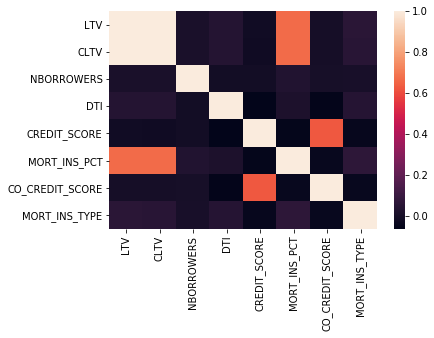

In [288]:
dfA1t = dfA1u.select_dtypes(include=['float64','int64','int8','uint8'])
dfA1t = dfA1t.dropna(axis=0,how='any')
import seaborn as sns
sns.heatmap(dfA1t[cl].corr())

In [313]:
#Seeing how well using regression to fill values for LTV using MORT_INS_PCT and vice versa works
test = dfA1u[['LTV','CLTV','MORT_INS_PCT']]
print(len(test))
t2 = test.dropna(axis=0,how='all')
t3 = test.dropna(axis=0,how='any')

len(t2)
ols = LinearRegression()

from sklearn.model_selection import train_test_split

Xtrain,Xtest,ytrain,ytest = train_test_split(t3['MORT_INS_PCT'],t3['CLTV'])
model = ols.fit(np.asarray(Xtrain).reshape(-1,1),ytrain)
preds = model.predict(np.asarray(Xtest).reshape(-1,1))
r2_score(ytest,preds)

156564


0.4312238787635293

In [305]:
#Seeing how well using credit score regression to fill values works
test = dfA1u[['CREDIT_SCORE','CO_CREDIT_SCORE']]
print(len(test))
t2 = test.dropna(axis=0,how='all')
print(len(t2))
t3 = test.dropna(axis=0,how='any')

Xtrain,Xtest,ytrain,ytest = train_test_split(t3['CREDIT_SCORE'],t3['CO_CREDIT_SCORE'])
model = ols.fit(np.asarray(Xtrain).reshape(-1,1),ytrain)
preds = model.predict(np.asarray(Xtest).reshape(-1,1))
r2_score(ytest,preds)

156564
154862


0.4918717594514025

- LTV<-->CLTV
- MORT_INS_PCT<-->LTV,CLTV
- CREDIT_SCORE<-->CO_CREDIT_SCORE


In [13]:
from sklearn.preprocessing import PolynomialFeatures
def create_regression_XY(dfA0,dfCF0,dfA1,dfCF1,i):
    dfA0n = dfA0.copy()
    name = 'Cumulative_Payment_'+str(i)
    dfA0n['Cumulative Payment'] = dfCF0[name]
    X = dfA0n.drop(['Cumulative Payment'],axis='columns')
    y = dfA0n['Cumulative Payment']
    
    poly = PolynomialFeatures(2)
    X_p = poly.fit_transform(X)
    names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_p)
    X.columns=names
    
    dfA1n = dfA1.copy()
    dfA1n['Cumulative Payment'] = dfCF1[name]
    X_test = dfA1n.drop(['Cumulative Payment'],axis='columns')
    y_test = dfA1n['Cumulative Payment']
    
    X_test_p = poly.fit_transform(X_test)
    names = poly.get_feature_names(X_test.columns)
    X_test = pd.DataFrame(X_test_p)
    X_test.columns=names
    return X,y,X_test,y_test

In [36]:
def create_classification_XY(dfA0,dfCF0,dfA1,dfCF1,i):
    dfA0n = dfA0.copy()
    name = 'Active_'+str(i)
    dfA0n['Active'] = dfCF0[name]
    X = dfA0n.drop(['Active'],axis='columns')
    y = dfA0n['Active']
    
    poly = PolynomialFeatures(2)
    X_p = poly.fit_transform(X)
    names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_p)
    X.columns=names
    
    dfA1n = dfA1.copy()
    dfA1n['Active'] = dfCF1[name]
    X_test = dfA1n.drop(['Active'],axis='columns')
    y_test = dfA1n['Active']
    lids = list(X_test.index)
    
    X_test_p = poly.fit_transform(X_test)
    names = poly.get_feature_names(X_test.columns)
    X_test = pd.DataFrame(X_test_p)
    X_test.columns=names
    return X,y,X_test,y_test,lids

In [15]:
XYs_12 = create_regression_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,12)
XYs_24 = create_regression_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,24)
XYs_36 = create_regression_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,36)
XYs_48 = create_regression_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,48)
XYs_60 = create_regression_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,60)

In [37]:
XYs_12_class = create_classification_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,12)
XYs_24_class = create_classification_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,24)
XYs_36_class = create_classification_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,36)
XYs_48_class = create_classification_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,48)
XYs_60_class = create_classification_XY(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,60)

In [55]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import ExtraTreesRegressor

def regression(XYs,m):
    X = XYs[0]
    y = XYs[1]
    X_test = XYs[2]
    y_test = XYs[3]
    ols = LinearRegression()
    #ols = ExtraTreesRegressor(n_estimators=20)
    model = ols.fit(X,y)
    pred = model.predict(X_test)
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    print('M='+str(m))
    print(r2_score(y_test,pred))
    print((mean_absolute_error(y_test,pred)))
    print('\n')

In [59]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
def classification(XYs,m):
    lids = XYs[4]
    X = XYs[0]
    y = XYs[1]
    X_test = XYs[2]
    y_test = XYs[3]
    ols = ExtraTreesClassifier(n_estimators=20,random_state=42)
    #ols = LogisticRegression()

    model = ols.fit(X,y)
    pred = model.predict(X_test)
    probs = model.predict_proba(X_test)

    from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
    
    print('M='+str(m))
    print(accuracy_score(y_test,pred))
    print(confusion_matrix(y_test,pred))
    off = np.asarray(((probs[:,1]-y_test)**2)**0.5).mean()
    print(mean_absolute_error(y_test,probs[:,1]))
    print(off)
    print('\n')
    return probs[:,1],X_test,y_test

In [56]:
regression(XYs_12,12)
regression(XYs_24,24)
regression(XYs_36,36)
regression(XYs_48,48)
regression(XYs_60,60)

M=12
0.29941067850759695
39922.61652249142


M=24
0.5299157668402321
48726.97250482252


M=36
0.761616326692681
26222.47505859877


M=48
0.8535575502936065
17232.37119794675


M=60
0.900651214451824
13047.305246662307




In [64]:
pXy_12df = pd.DataFrame(pXy_12[2])
pXy_12df['Prob'] = pXy_12[0]
off = np.asarray(((pXy_12df['Prob']-pXy_12df['Active'])**2)**0.5).mean()

In [23]:
classification(XYs_12_class,12)
classification(XYs_24_class,24)
classification(XYs_36_class,36)
classification(XYs_48_class,48)
classification(XYs_60_class,60)

M=12
0.8296671009938428
[[  6276  20918]
 [  5750 123620]]
0.2512863749009989


M=24
0.6533238803300887
[[55037 24705]
 [29572 47250]]
0.41504592371170895


M=36
0.7922958023555862
[[116950   6001]
 [ 26518   7095]]
0.28929143992233214


M=48
0.8613410490278736
[[132597   2485]
 [ 19224   2258]]
0.21281345009069771


M=60
0.8987378963235482
[[139782   1208]
 [ 14646    928]]
0.16704047546051454




# Testing on CF1: Final Results

### Regression (Cumulative Payment)
#### Format:

M=(# of months)
- R2 score
- Mean absolute error

M=12
- 0.29941067850759695
- 39922.61652249142


M=24
- 0.5299157668402321
- 48726.97250482252


M=36
- 0.761616326692681
- 26222.47505859877


M=48
- 0.8535575502936065
- 17232.37119794675


M=60
- 0.900651214451824
- 13047.305246662307

### Classification (Active or Not Active)

Format:

M=(# of months)
- Accuracy Score
- Confusion Matrix
- Average absolute diffence p-hat minus Y

M=12
- 0.8296671009938428
- [[  6276  20918]
[  5750 123620]]
- 0.2512863749009989


M=24
- 0.6533238803300887
- [[55037 24705]
 [29572 47250]]
- 0.41504592371170895


M=36
- 0.7922958023555862
- [[116950   6001]
 [ 26518   7095]]
- 0.28929143992233214


M=48
- 0.8613410490278736
- [[132597   2485]
 [ 19224   2258]]
- 0.21281345009069771


M=60
- 0.8987378963235482
- [[139782   1208]
 [ 14646    928]]
- 0.16704047546051454

# Different Classifcation Model Scores on m=24
- Logistic:
    - 0.64749
    - abs prob error: .4415
- ExtraTrees:
    - 0.6536
    - abs prob error: .415
    - Using average UPB and 
    - Note: Using regression fill slightly improves performance of the extra trees classifier
- KNN
    - .62
- SGD
    - .49
    - Out of box, would likely perform better with hyperparameter tuning but this seemed bad enough out of box to not spend a lot of time on

In [26]:
#What percent of loans in the test set are active for m=24
y_test = XYs_24_class[3]
zeros = list(y_test).count(0)
length = len(list(y_test))
zeros/length

0.5093252599575893

In [61]:
df1 = dfA1r.copy()
df1['Active_24'] = dfCF1_summary['Active_24']
X = df1.drop('Active_24',axis=1)
y = df1['Active_24']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, test_size=.7)

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(1000, input_dim=len(list(X.columns)), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=5)

_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
46969/46969 [==============================] - 33s 706us/step - loss: 53.1985 - accuracy: 0.5039 1s - loss: 55.
Epoch 2/10
46969/46969 [==============================] - 35s 741us/step - loss: 0.7678 - accuracy: 0.5080
Epoch 3/10
38335/46969 [=======================>......] - ETA: 5s - loss: 0.7253 - accuracy: 0.5084

KeyboardInterrupt: 

In [32]:
#Using statsmodels to easily look at p-values for different parameters to try to reduce dimesnionality
import statsmodels.api as sm

X = X_train
#X = X[newlist]
y = y_train
#X_test = X_test[newlist]

X_sm = sm.add_constant(X)

model = sm.OLS(list(y), X_sm).fit()
predictions = model.predict(X_sm) 

print_model = model.summary()
print(print_model)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     655.9
Date:                Tue, 11 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:30:15   Log-Likelihood:                -69643.
No. Observations:              109594   AIC:                         1.394e+05
Df Residuals:                  109560   BIC:                         1.397e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
INT_RATE               -0.2310    

In [21]:
#Selecting attributes from statsmodels summary from based on their p-values. 
#Using the 'newlist' in the block above to re-run the model with selected attributes
LRresult = model.summary2().tables[1]
newlist = list(LRresult[LRresult['P>|t|']<=0.10].index)[1:]
newlist

['INT_RATE',
 'UPB',
 'TERM',
 'OCHANNEL_R',
 'OCC_STATUS_I',
 'PROPERTY_TYPE_PU',
 'INT_RATE^2',
 'INT_RATE UPB',
 'INT_RATE TERM',
 'INT_RATE FIRST_PMT_DATE',
 'INT_RATE CREDIT_SCORE',
 'INT_RATE ZIP',
 'INT_RATE MORT_INS_TYPE',
 'INT_RATE STATE_MEDIAN_INCOME',
 'INT_RATE STATE_LL',
 'INT_RATE OCHANNEL_B',
 'INT_RATE OCHANNEL_C',
 'INT_RATE OCHANNEL_R',
 'INT_RATE OCC_STATUS_I',
 'INT_RATE OCC_STATUS_P',
 'INT_RATE OCC_STATUS_S',
 'INT_RATE FIRST_TIME_IND_N',
 'INT_RATE FIRST_TIME_IND_Y',
 'INT_RATE LOAN_PURPOSE_U',
 'INT_RATE PROPERTY_TYPE_CO',
 'INT_RATE PROPERTY_TYPE_CP',
 'INT_RATE PROPERTY_TYPE_MH',
 'INT_RATE PROPERTY_TYPE_PU',
 'INT_RATE PROPERTY_TYPE_SF',
 'UPB^2',
 'UPB TERM',
 'UPB FIRST_PMT_DATE',
 'UPB NBORROWERS',
 'UPB CREDIT_SCORE',
 'UPB NUNITS',
 'UPB MORT_INS_TYPE',
 'UPB REL_MORT_IND',
 'UPB STATE_LL',
 'UPB STATE_UPB',
 'UPB ZIP_LL',
 'UPB ZIP_UPB',
 'TERM NBORROWERS',
 'TERM ZIP',
 'TERM OCHANNEL_B',
 'TERM OCHANNEL_C',
 'TERM OCHANNEL_R',
 'TERM OCC_STATUS_I',
 

# Null Hypothesis:
- Using the average of the training set as the prediction for every value of the testing set, you get a mean absolute error of 87767.37 for m=24

In [29]:
#Null hypothesis
from sklearn.metrics import mean_squared_error
y = XYs_24[1]
y_test = XYs_24[3]
len(y_test)
null_pred = []
for i in range(len(y_test)):
    null_pred.append(y.mean())
print(mean_squared_error(y_test,null_pred)**.5)

87767.36819016135


# Test 1
- Linear Regression (including Lasso and Ridge)
    - .503 R2 score training on entirty of data set 0 and testing on entirety of data set 1
    - Mean absolute error of 61857.76
        - An improvement over the null hypothesis, but probably could be better
- ExtraTreesRegressor performed worse than LinearRegression
- Things to play with:
    - representing date in a different way
    - representing state in a different way
    - dealing with NaN values differently (currently used mean of row, this probably could be better)
    
# Test 2
- Filled some NaN values with regression values (used other highly correlated stats to predict the values instead of simply using mean)
- Used polynomial features
- Results:
    - For the stats that I opted to use regression values instead of mean values to fill NaN, there was not significant difference in model performance. I still want to play with doing this for more NaN fills, as in theory it should perform better
    - Using polynomial features reduced mean absolute error from 61857.7559 to 60714.70 and increased R2 from .50 to .52 on test
    
# Test 3
- Tried training the model only on rows that had no NaN values to begin with (as opposed to training on all of the rows with filled NaNs)
- Results:
    -  R2 and Absolute Error scores were slightly worse
    
# Test 4
- Now have been playing around with the classification model a bunch. Have tried a bunch of different models, logistic and extratrees seem to work the best. ExtraTrees worked the best to start, but while testing I decided to do something kind of interesting which was use averages for loan length and UPB from JUST MY TRAINING DATA (very cognisant to avoid data leakage) as ways to represent zip codes and states. This helped both models, but logistic regression a lot more. I am assuming this is because ET probably handled the zip codes better just as they were

# Test 5
- For cumulative payment, tried to see what happened if ran the regression once, removed all of the parameters with p>0.05, and then ran again
    - With significantly less parameters, I got very very similar (albiet slightly worse) results
    - Even though it is very cool that I was able to get really similar results with way less parameters, the bottom line it with bost testing on the "1" data sets as well as splitting the "0" datasets and training and testing on split data, the results were consistently slightly worse. Because the run time was already managable, this is probably something I will not keep

# Test 6
- Played around with using regression fill for all of the columns that have NaN values
- Up to this point, I used regression fill to fill values for columns that had at least one other column that was highly correlated to it, which makes regression fill very useful. But I wanted to see how much improvement I could get by using it for all categories
- Results:
    - Not much improvement. The difference in mean_absolute_error of the regression filled data and just filling with the mean was in the range of 1-2% improvement for all of the columns that I tried it for. Decided that this meant it was likely not worth implementing

# Test 7
- Tried representing some of the categorical data with hashing instead of OHE
- Performance did not improve and actually got worse, which is honestly what I expected. All of the columns I tried this for only had between 3-5 categories, so OHE is probably going to be the best way to represent those
    

### Possible methods to convert categorical data to numerical considered:
- Hashing
- One hot encoiding
- Using state population/GDP or the like as a way to represent states
- Cat2vec
    - Only would've really made sense for state, but got good results using state ecnomic data

# Making the Predictions on A2

In [71]:
# Creating total training set
def create_classification_XY_for_2pred(dfA0,dfCF0,dfA1,dfCF1,i):
    dfA0n = dfA0.copy()
    dfA1n = dfA1.copy()
    dfAtot = pd.concat([dfA0n,dfA1n],axis='index')
    
    dfCFtot = pd.concat([dfCF0,dfCF1],axis='index')
    
    name = 'Active_'+str(i)
    dfAtot['Active'] = dfCFtot[name]
    X = dfAtot.drop(['Active'],axis='columns')
    y = dfAtot['Active']
    
    poly = PolynomialFeatures(2)
    X_p = poly.fit_transform(X)
    names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_p)
    X.columns=names
    return X,y

In [87]:
# Creating total training set
def create_regression_XY_for_2pred(dfA0,dfCF0,dfA1,dfCF1,i):
    dfA0n = dfA0.copy()
    dfA1n = dfA1.copy()
    dfAtot = pd.concat([dfA0n,dfA1n],axis='index')
    
    dfCFtot = pd.concat([dfCF0,dfCF1],axis='index')
    
    name = 'Cumulative_Payment_'+str(i)    
    dfAtot['Cumulative Payment'] = dfCFtot[name]
    X = dfAtot.drop(['Cumulative Payment'],axis='columns')
    y = dfAtot['Cumulative Payment']
    
    poly = PolynomialFeatures(2)
    X_p = poly.fit_transform(X)
    names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_p)
    X.columns=names
    return X,y

In [80]:
def create_classification_X_test_for_2pred(dfA2,i):
    dfA2n = dfA2.copy()
    lids = list(dfA2n.index) 
    X = dfA2n
    
    poly = PolynomialFeatures(2)
    X_p = poly.fit_transform(X)
    names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_p)
    X.columns=names
    return X,lids

In [77]:
XYs_12_class = create_classification_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,12)
XYs_24_class = create_classification_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,24)
XYs_36_class = create_classification_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,36)
XYs_48_class = create_classification_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,48)
XYs_60_class = create_classification_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,60)

In [88]:
XYs_12 = create_regression_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,12)
XYs_24 = create_regression_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,24)
XYs_36 = create_regression_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,36)
XYs_48 = create_regression_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,48)
XYs_60 = create_regression_XY_for_2pred(dfA0r,dfCF0_summary,dfA1r,dfCF1_summary,60)

In [81]:
#Classification and rergression X_test for A2 are the same
X_12_class_2 = create_classification_X_test_for_2pred(dfA2r,12)
X_24_class_2 = create_classification_X_test_for_2pred(dfA2r,24)
X_36_class_2 = create_classification_X_test_for_2pred(dfA2r,36)
X_48_class_2 = create_classification_X_test_for_2pred(dfA2r,48)
X_60_class_2 = create_classification_X_test_for_2pred(dfA2r,60)

In [90]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
def classification_on_2(XYs_train,Xs_test,m):
    lids = Xs_test[1]
    X = XYs_train[0]
    y = XYs_train[1]
    X_test = Xs_test[0]
    
    ols = ExtraTreesClassifier(n_estimators=20,random_state=42)
    #ols = LogisticRegression()

    model = ols.fit(X,y)
    pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    
    print('M='+str(m))
    print('\n')
    name = 'p('+str(m)+')'
    df = pd.DataFrame({'LID':lids,name:probs[:,1]})
    df.set_index('LID',inplace=True)
    return df

In [92]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import ExtraTreesRegressor

def regression_on_2(XYs_train,Xs_test,m):
    lids = Xs_test[1]
    X = XYs_train[0]
    y = XYs_train[1]
    X_test = Xs_test[0]
    
    ols = LinearRegression()
    #ols = ExtraTreesRegressor(n_estimators=20)
    model = ols.fit(X,y)
    pred = model.predict(X_test)
        
    print('M='+str(m))
    print('\n')
    name = 'r('+str(m)+')'
    df = pd.DataFrame({'LID':lids,name:pred})
    df.set_index('LID',inplace=True)
    return df

In [93]:
df12_class = classification_on_2(XYs_12_class,X_12_class_2,12)
df24_class = classification_on_2(XYs_24_class,X_24_class_2,24)
df36_class = classification_on_2(XYs_36_class,X_36_class_2,36)
df48_class = classification_on_2(XYs_48_class,X_48_class_2,48)
df60_class = classification_on_2(XYs_60_class,X_60_class_2,60)

M=12


M=24


M=36


M=48


M=60




In [94]:
df12_reg = regression_on_2(XYs_12,X_12_class_2,12)
df24_reg = regression_on_2(XYs_24,X_24_class_2,24)
df36_reg = regression_on_2(XYs_36,X_36_class_2,36)
df48_reg = regression_on_2(XYs_48,X_48_class_2,48)
df60_reg = regression_on_2(XYs_60,X_60_class_2,60)

M=12


M=24


M=36


M=48


M=60




In [95]:
finaldf = pd.concat([df12_class,df24_class,df36_class,df48_class,df60_class,df12_reg,df24_reg,df36_reg,df48_reg,df60_reg],axis='columns')
finaldf.to_csv('predictions.csv')